# 51_이미지 증강

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# 클래스 개수는 5
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [4]:
# 클래스 종류
get_label_name = metadata.features['label'].int2str
[get_label_name(n) for n in range(5)]

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

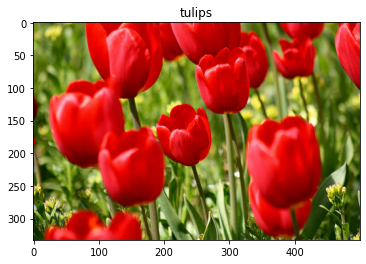

In [5]:
get_label_name  = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1. / 255)
])

# Rescaling(1./127.5, offset=-1) 이란 옵션도 있다.

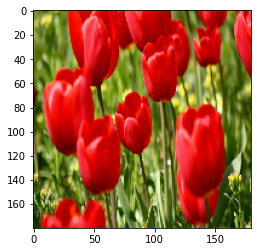

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [8]:
print('Min and max pixel values:', result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [9]:
# 데이터 회전과 관련된 증강
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

-------------------------

In [10]:
# tf.extend_dims의 역할
image.shape

TensorShape([333, 500, 3])

In [14]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

In [15]:
image.shape

TensorShape([1, 333, 500, 3])

-------------------------

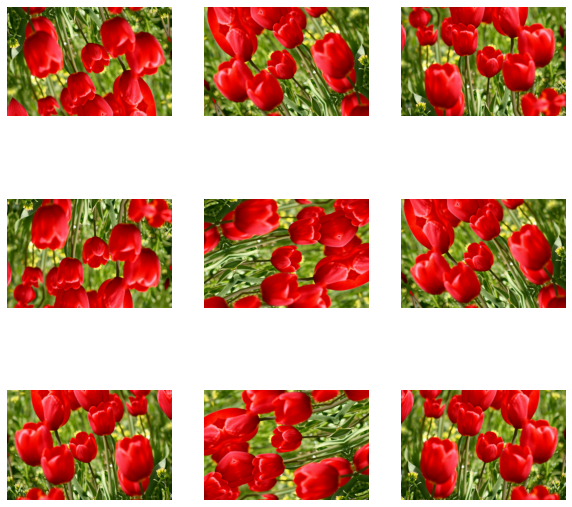

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(augmented_image[0])
    # WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    # https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

    plt.imshow(augmented_image[0]/255.)
    plt.axis('off')


In [22]:
# 증강을 모델에 구성하기
model = tf.keras.Sequential([
                             resize_and_rescale,
                             data_augmentation,
                             layers.Conv2D(16, 3, padding='same', activation='relu'),
                             layers.MaxPooling2D(),
                             # Rest of your model
])

# 데이터 증강은 나머지 레이어와 동기적으로 기기에서 실행되며 GPU 가속을 이용
# model.fit(model.evaluate 또는 model.predict 가 아님) 호출 중에만 증강

In [23]:
# 이렇게도 사용할 수 있다.
aug_ds = train_ds.map(
    lambda x, y : (resize_and_rescale(x, training=True), y)
)

In [24]:
# 데이터 증강을 위한 구성

batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
        
    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
# 데이터구성
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [26]:
# 모델 구성
model = tf.keras.Sequential([
                             layers.Conv2D(16, 3, padding='same', activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, padding='same', activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(64, 3, padding='same', activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)
])

In [28]:
# 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [29]:
# 학습
epochs = 5
history = model.fit(
    train_ds, 
    validation_data = val_ds,
)

Epoch 1/5
92/92 [==============================] - 26s 133ms/step - loss: 1.5954 - accuracy: 0.2558 - val_loss: 1.5851 - val_accuracy: 0.2916
Epoch 2/5
92/92 [==============================] - 11s 110ms/step - loss: 1.5835 - accuracy: 0.2834 - val_loss: 1.5846 - val_accuracy: 0.2888
Epoch 3/5
92/92 [==============================] - 11s 117ms/step - loss: 1.5648 - accuracy: 0.2899 - val_loss: 1.5981 - val_accuracy: 0.1989
Epoch 4/5
92/92 [==============================] - 12s 119ms/step - loss: 1.5604 - accuracy: 0.2912 - val_loss: 1.5644 - val_accuracy: 0.2752
Epoch 5/5
92/92 [==============================] - 11s 111ms/step - loss: 1.5480 - accuracy: 0.3059 - val_loss: 1.5893 - val_accuracy: 0.2507


In [30]:
# 결과
loss, acc = model.evaluate(test_ds)
print('Accuracy', acc)

12/12 [==============================] - 1s 73ms/step - loss: 1.6096 - accuracy: 0.1771
Accuracy 0.17711171507835388


In [31]:
# 람다 레이어를 이용한 데이터 증강
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [32]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

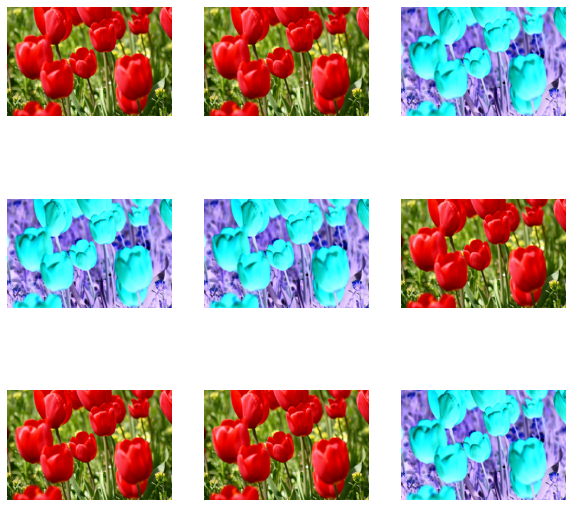

In [33]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

-------------------

In [34]:
# 혹은 서브클래스를 이용해서
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

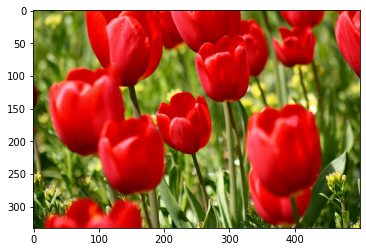

In [35]:
_ = plt.imshow(RandomInvert()(image)[0])

-----------------

In [36]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

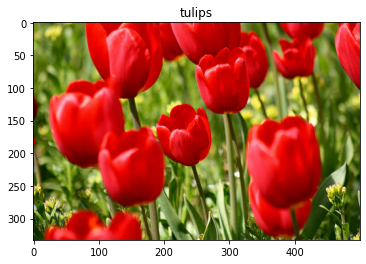

In [37]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [38]:
# 비교함수
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

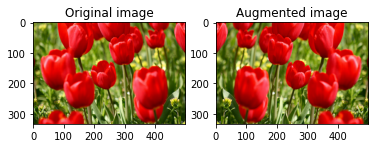

In [39]:
# tf.image의 뒤집기
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

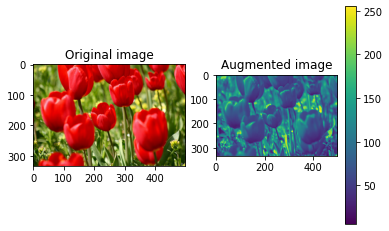

In [40]:
# tf.image의 gray
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

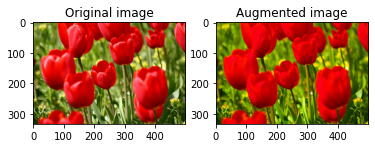

In [41]:
# 채도 변화를 이용한 증강
saturated  = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

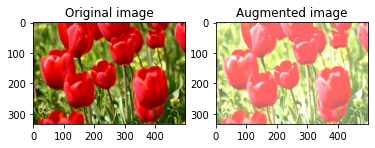

In [42]:
# 밝기 변화
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

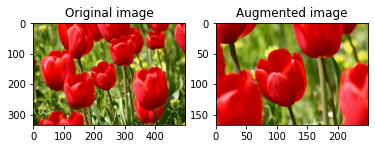

In [43]:
# 이미지 자르기
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

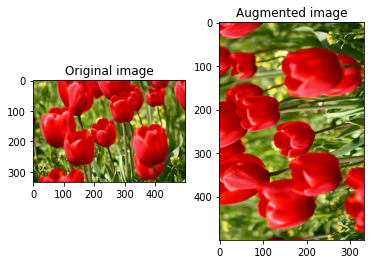

In [44]:
# 90도 회전
rotated  = tf.image.rot90(image)
visualize(image, rotated)

In [45]:
# 증강코드 함수화
def resize_and_rescale(image,label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image  (image / 255.0)
    return image, label

In [46]:
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# 데이터 구성

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)